In [1]:
%env OMP_NUM_THREADS = 1

from firedrake import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os
from egfcore_pacman import *

env: OMP_NUM_THREADS=1


In [2]:
%%time
add_noise = False
noise_level = 0.1
paramSet = np.array([[0.4*pi], [0.5*pi], [0.6*pi], [0.55*pi]])
verbose = False

sigma = 0.2
rank = 200
nSamples = rank
    
models = []

for p, params in enumerate(paramSet):
    print(f"Method: Randomized SVD | param: {params}, sigma: {sigma}, nSamples: {nSamples}, rank: {rank}")
    Sim = Simulator(params)
    forcing = sampleforcing2D(sigma, nSamples)
    solution = np.zeros(forcing.shape)
    for i in range(solution.shape[1]):
        if verbose:
            print("i = %d / %d"%(i+1, solution.shape[1]))
        if add_noise:
            solution[:,i] = Sim.solve(forcing[:,i], noise_level, params[0])
        else:
            solution[:,i] = Sim.solve(forcing[:,i], None, params[0])

        model = EGF("randomized-svd", params, rank, Sim.mesh, forcing, solution, None, None, None, Sim, verbose = verbose)
    
    models.append(model)

Method: Randomized SVD | param: [1.25663706], sigma: 0.2, nSamples: 200, rank: 200
Method: Randomized SVD | param: [1.57079633], sigma: 0.2, nSamples: 200, rank: 200
Method: Randomized SVD | param: [1.88495559], sigma: 0.2, nSamples: 200, rank: 200
Method: Randomized SVD | param: [1.72787596], sigma: 0.2, nSamples: 200, rank: 200
CPU times: user 1h 17min 59s, sys: 15min 27s, total: 1h 33min 26s
Wall time: 3h 35min 22s


Text(0.5, 0.98, 'Mode 50')

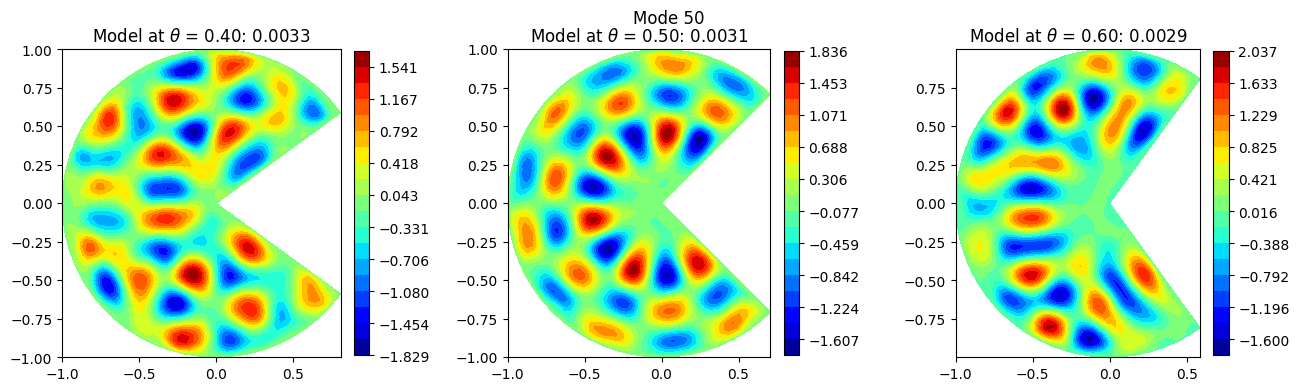

In [3]:
i = 50

plt.figure(figsize = (14,4))
plt.tight_layout()
plt.subplots_adjust(left = 0.05, wspace=0.3, hspace=0.3)
for m in range(3):
    plt.subplot(1,3,m+1)
    mode = models[m].modeset[:,i]
    mesh = models[m].mesh
    V = FunctionSpace(mesh, "CG", 3)
    u = Function(V)
    u.dat.data[:] = mode
    levels = np.linspace(np.min(mode), np.max(mode), 20)
    contours = tricontourf(u, levels = levels, axes = plt.gca(),cmap="jet")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar(contours, fraction=0.046, pad=0.04)
    plt.title(f'Model at $\\theta$ = {models[m].params[0]/pi:.2f}: {models[m].dcoeffs[i,0]:.4f}')
    
plt.suptitle(f'Mode {i}')

Text(0.5, 0.98, 'Mode 8')

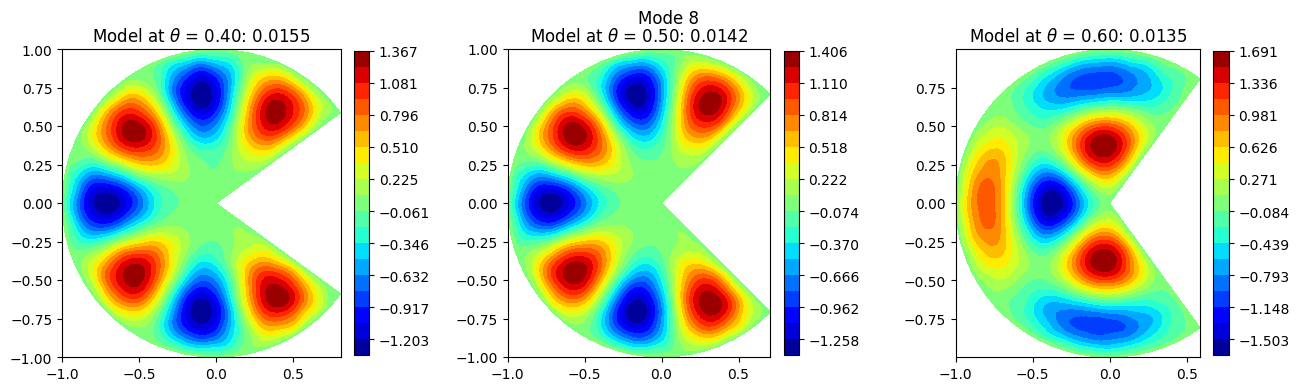

In [4]:
i = 8

plt.figure(figsize = (14,4))
plt.tight_layout()
plt.subplots_adjust(left = 0.05, wspace=0.3, hspace=0.3)
for m in range(3):
    plt.subplot(1,3,m+1)
    mode = models[m].modeset[:,i]
    mesh = models[m].mesh
    V = FunctionSpace(mesh, "CG", 3)
    u = Function(V)
    u.dat.data[:] = mode
    levels = np.linspace(np.min(mode), np.max(mode), 20)
    contours = tricontourf(u, levels = levels, axes = plt.gca(),cmap="jet")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar(contours, fraction=0.046, pad=0.04)
    plt.title(f'Model at $\\theta$ = {models[m].params[0]/pi:.2f}: {models[m].dcoeffs[i,0]:.4f}')
    
plt.suptitle(f'Mode {i}')

In [ ]:
%%time

print(f"Parameter set: {paramSet}")
interpSet = [models[0], models[1], models[2]]
# interpSet = [models[0], models[2]]

targetParam = paramSet[-1]
targetModel = models[-1]
inputdata = models[-1].forcing #compute_forcing(pSim.mesh, numSteps)
simulator = Sim

interpModel, U_set, coeffs_set = model_interp(interpSet, inputdata, targetParam, verbose = False)

Parameter set: [[1.25663706]
 [1.57079633]
 [1.88495559]
 [1.72787596]]
CPU times: user 1.49 s, sys: 44.9 ms, total: 1.54 s
Wall time: 1.67 s


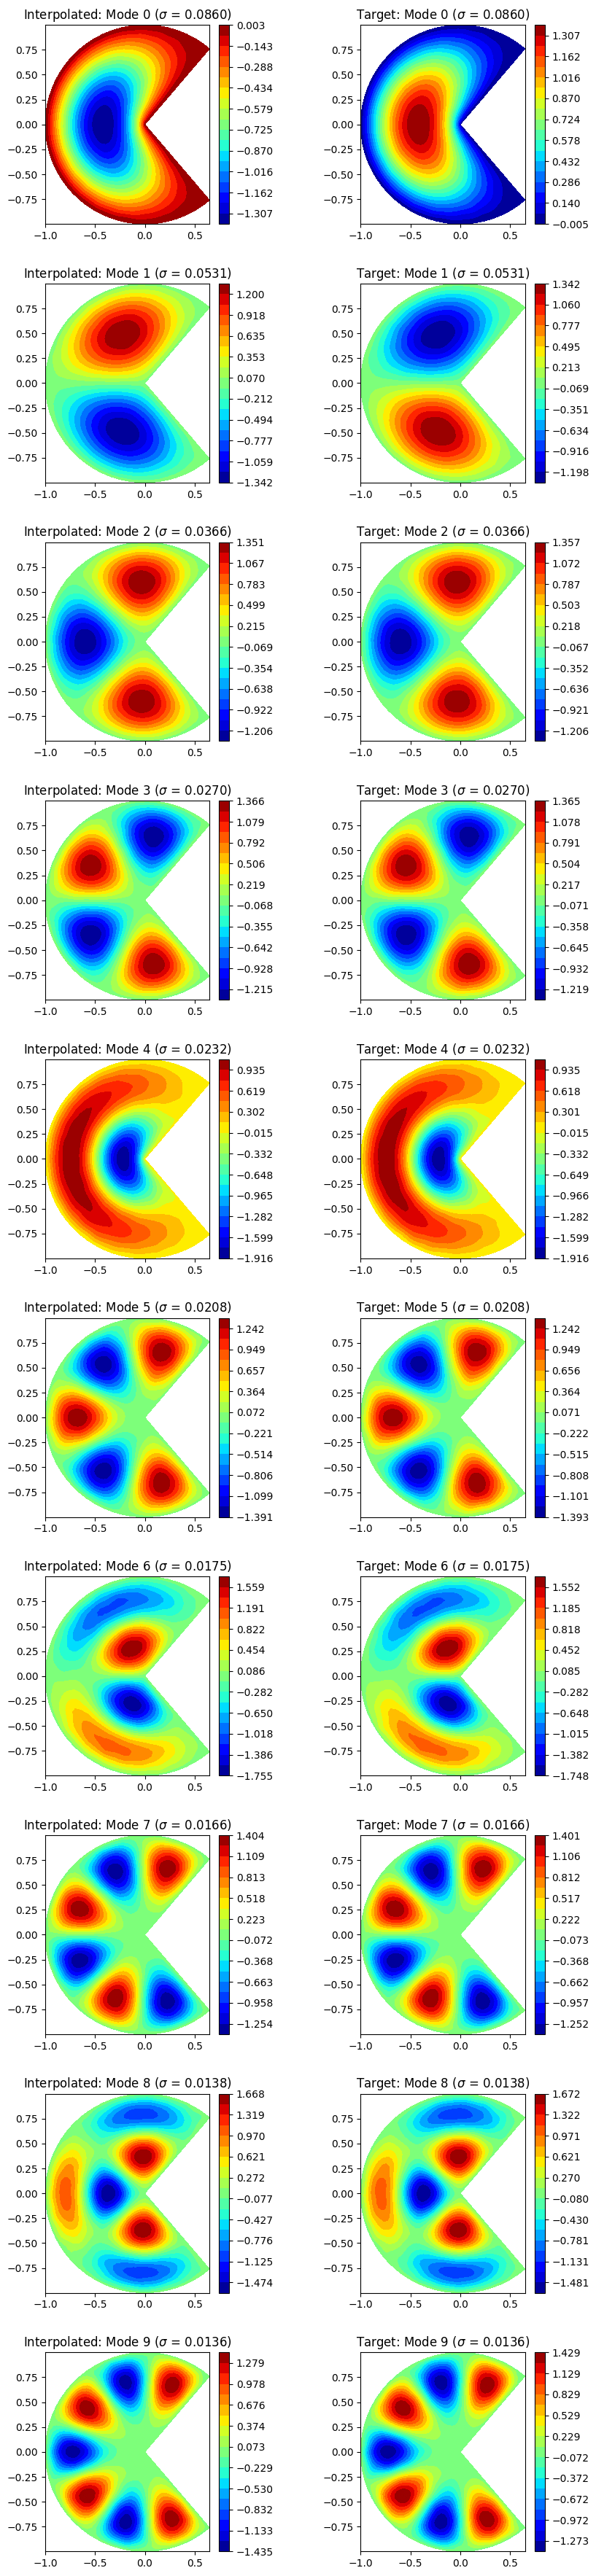

In [ ]:
# i = 29

plt.figure(figsize = (9,4.5*10))
plt.tight_layout()
plt.subplots_adjust(left = 0.05, wspace=0.3, hspace=0.3)

for i in range(10):
    plt.subplot(10,2,i*2+1)
    mode = interpModel.modeset[:,i]
    mesh = interpModel.mesh
    V = FunctionSpace(mesh, "CG", 3)
    u = Function(V)
    u.dat.data[:] = mode
    levels = np.linspace(np.min(mode), np.max(mode), 20)
    contours = tricontourf(u, levels = levels, axes = plt.gca(),cmap="jet")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar(contours, fraction=0.046, pad=0.04)
    plt.title(f'Interpolated: Mode {i} ($\\sigma$ = {interpModel.dcoeffs[i]:.4f})')

    plt.subplot(10,2,2*i+2)
    mode = targetModel.modeset[:,i]
    mesh = targetModel.mesh
    V = FunctionSpace(mesh, "CG", 3)
    u = Function(V)
    u.dat.data[:] = mode
    levels = np.linspace(np.min(mode), np.max(mode), 20)
    contours = tricontourf(u, levels = levels, axes = plt.gca(),cmap="jet")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar(contours, fraction=0.046, pad=0.04)
    plt.title(f'Target: Mode {i} ($\\sigma$ = {targetModel.dcoeffs[i,0]:.4f})')
# plt.suptitle(f'Models at $\\theta$ = {targetModel.params[0]/pi:.2f}')

In [ ]:
order, signs = compute_order_and_signs(targetModel.modeset, interpModel.modeset)
modes = interpModel.modeset[order]*signs
dcoeffs = interpModel.dcoeffs[order]

Text(0.5, 1.0, 'Comparison between coefficients')

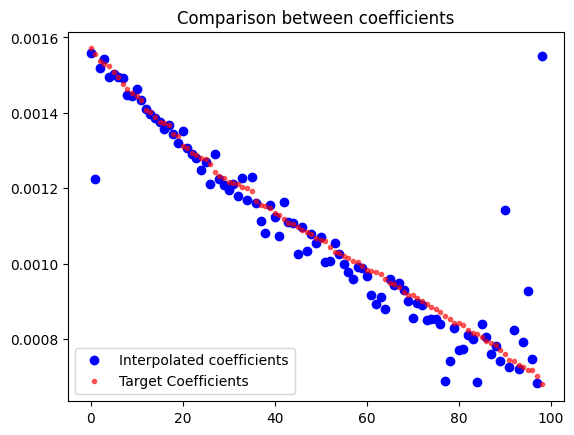

In [ ]:
start, end = 100,199
plt.figure()
plt.plot(dcoeffs[start:end],'bo')
plt.plot(targetModel.dcoeffs[start:end],'r.', alpha = 0.6)
plt.legend(['Interpolated coefficients', 'Target Coefficients'])
plt.title('Comparison between coefficients')

In [ ]:
def plotGpaper(interpModel, targetModel):
    # vminIndex = np.array([-0.1,-1.4,-1.7,-1.5])
    # vmaxIndex = np.array([1.4,1.4,1.7,1.5])
    vminIndex = np.array([None, None, None, None])
    vmaxIndex = np.array([None, None, None, None])
    
    # i = 29

    fig = plt.figure(figsize = (4.5*4,9))
    plt.tight_layout()
    plt.subplots_adjust(left = 0.05, wspace=0.3, hspace=0.3)
    
    Index = np.array(['A','B','C','D'])
    # modeIndex = np.array([0, 2, 8, 9])
    modeIndex = np.array([-10, -30, -90, -100])
    
    signs = np.array([-1,1,1,1])
    for j,i in enumerate(modeIndex):
        vmin = vminIndex[j]
        vmax = vmaxIndex[j]
        plt.subplot(2,4,j+1)
        mode = interpModel.modeset[:,i]*signs[j]
        mesh = interpModel.mesh
        V = FunctionSpace(mesh, "CG", 3)
        u = Function(V)
        u.dat.data[:] = mode
        plt.gca().set_aspect('equal')
        
        if vmin is None:
            contours = tricontourf(u, axes = plt.gca(), cmap="jet")
            plt.colorbar(contours, fraction=0.046, pad=0.04)
        else:
            levels = np.linspace(vmin, vmax, 20)
            contours = tricontourf(u, levels = levels, axes = plt.gca(), cmap="jet")
            plt.colorbar(contours, fraction=0.046, pad=0.04, ticks = np.linspace(vmin, vmax, 11))
        
        plt.title(f'Mode {i} ($\\sigma$ = {interpModel.dcoeffs[i]:.4f})')
        plt.xticks([-1.0,0,1.0])
        plt.yticks([-1.0,0,1.0])
        plt.xlabel('$x_1$')
        plt.ylabel('$x_2$', rotation='horizontal', labelpad=5)
        plt.title(Index[j],loc ='left', weight = 'bold', size = 12)
    
    Index = np.array(['E','F','G','H'])
    for j,i in enumerate(modeIndex):
        vmin = vminIndex[j]
        vmax = vmaxIndex[j]
        plt.subplot(2,4,4+j+1)
        mode = targetModel.modeset[:,i]
        mesh = targetModel.mesh
        V = FunctionSpace(mesh, "CG", 3)
        u = Function(V)
        u.dat.data[:] = mode
        plt.gca().set_aspect('equal')
        if vmin is None:
            contours = tricontourf(u, axes = plt.gca(), cmap="jet")
            plt.colorbar(contours, fraction=0.046, pad=0.04)
        else:
            levels = np.linspace(vmin, vmax, 20)
            contours = tricontourf(u, levels = levels, axes = plt.gca(), cmap="jet")
            plt.colorbar(contours, fraction=0.046, pad=0.04, ticks = np.linspace(vmin, vmax, 11))
        plt.title(f'Mode {i} ($\\sigma$ = {targetModel.dcoeffs[i,0]:.4f})')
        plt.xticks([-1.0,0,1.0])
        plt.yticks([-1.0,0,1.0])
        plt.xlabel('$x_1$')
        plt.ylabel('$x_2$', rotation='horizontal', labelpad=5)
        plt.title('D',loc ='left', weight = 'bold', size = 12)
        plt.title(Index[j],loc ='left', weight = 'bold', size = 12)
    
    fig.savefig('pacman.png', dpi=fig.dpi)

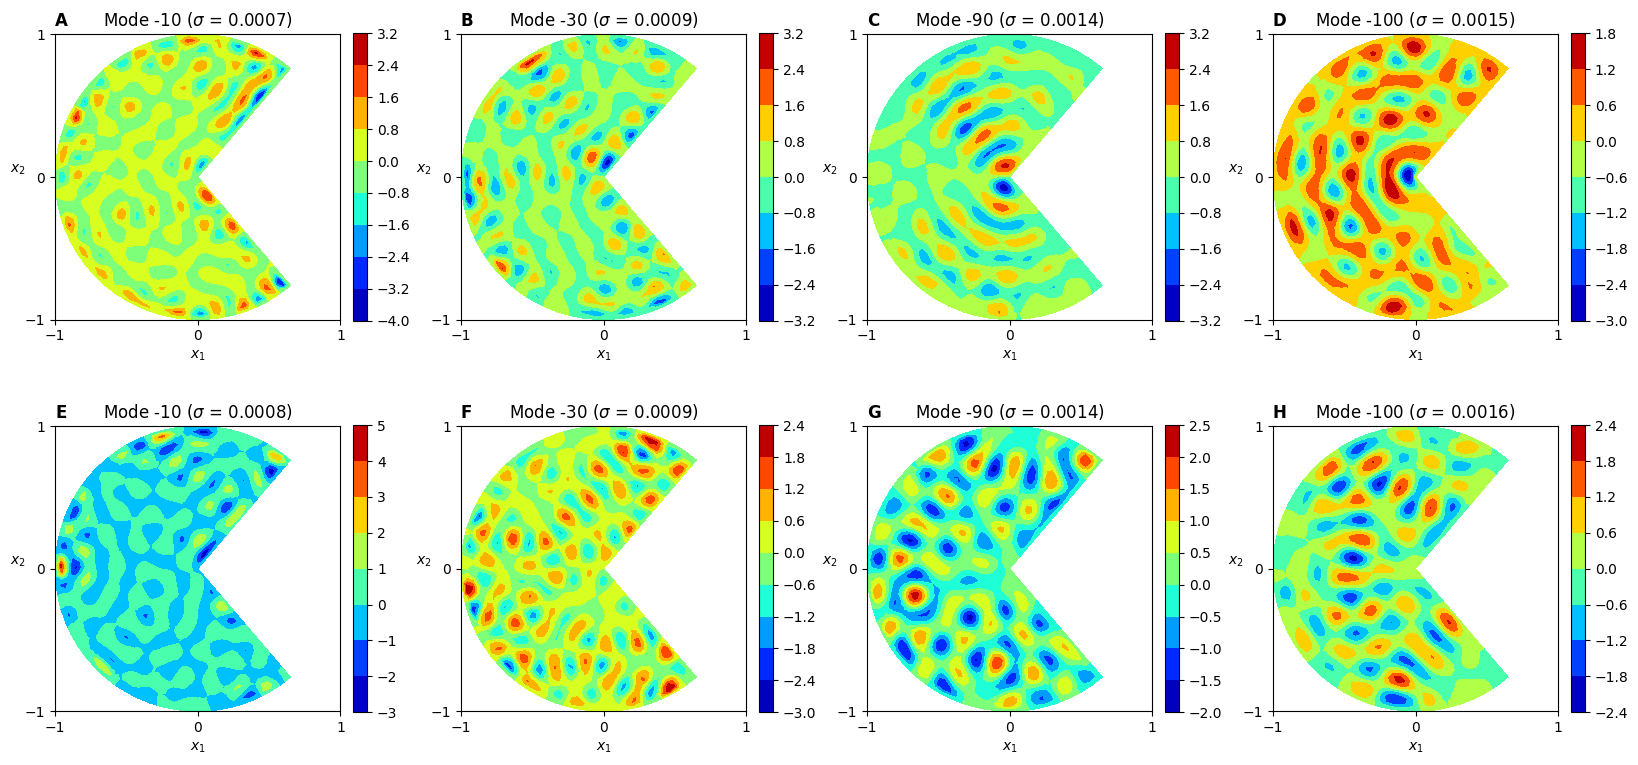

In [ ]:
plotGpaper(interpModel, targetModel)